<a href="https://colab.research.google.com/github/epigos/house-prices-prediction/blob/main/house_rental_prices_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
# some builtin imports
import re
import warnings
from collections import Counter
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Some usual imports here
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import stats modules
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms

# sklearn models
from sklearn.preprocessing import StandardScaler

# import geo libs
import geopandas as gpd
import folium as fm
from folium.plugins import HeatMap, MarkerCluster
from shapely.geometry import Point, Polygon

In [185]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [186]:
## Customize Matplotlib Parameters
%matplotlib inline
mpl.rcParams['figure.dpi']= 120
mpl.rcParams['figure.edgecolor']= 'black'
mpl.rcParams['axes.linewidth']= .5
# Customize Seaborn Parameters
sns.set()
rc = {
      'font.family': ['serif'],
      'font.serif':'Times New Roman',
      'grid.color': 'gainsboro',
      'grid.linestyle': '-',
}
sns.set_style(rc=rc)
sns.set_context("notebook", font_scale=0.8)

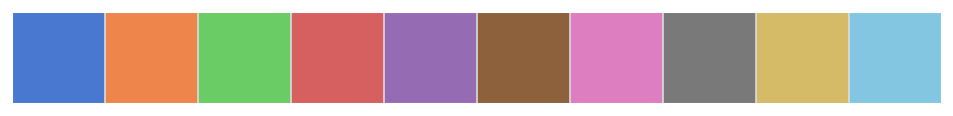

In [187]:
### choose set2 as the default color
color_set = sns.color_palette("muted")

## Set Seaborn Color Palette
sns.set_palette(color_set)

## Visualize Color Palette
sns.palplot(color_set)

# Load dataset

In [188]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/house_rentals.csv')

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            17890 non-null  object 
 1   listing_type   17890 non-null  object 
 2   name           17890 non-null  object 
 3   price          17890 non-null  int64  
 4   category       17890 non-null  object 
 5   bedrooms       17890 non-null  float64
 6   bathrooms      17890 non-null  float64
 7   floor_area     17890 non-null  float64
 8   location       17890 non-null  object 
 9   condition      17890 non-null  object 
 10  amenities      17890 non-null  object 
 11  region         17890 non-null  object 
 12  locality       17890 non-null  object 
 13  parking_space  17890 non-null  bool   
 14  is_furnished   17890 non-null  object 
 15  lat            17890 non-null  float64
 16  lng            17890 non-null  float64
dtypes: bool(1), float64(5), int64(1), object(10)
memor

In [190]:
df.head()

,url,listing_type,name,price,category,bedrooms,bathrooms,floor_area,location,condition,amenities,region,locality,parking_space,is_furnished,lat,lng
0,https://tonaton.com/a-MfYFNdCgCTytOcmvZIh0Kzrj...,rentals,"2bdrm Apartment in Charclem Ventures, East Leg...",9196,Flats,2.0,2.0,145.0,"Greater Accra, East Legon",Used,"24-hour Electricity,Air Conditioning,Balcony,C...",Greater Accra,East Legon,False,Semi-Furnished,5.635828,-0.161359
1,https://tonaton.com/a-MfYFNdCgwtb8Itol9odpMPvC...,rentals,"2bdrm Apartment in , Dzorwulu for rent",7500,Flats,2.0,2.0,100.0,"Greater Accra, Dzorwulu",Used,"24-hour Electricity,Air Conditioning,Apartment...",Greater Accra,Dzorwulu,False,Unfurnished,5.614123,-0.195647
2,https://tonaton.com/a-MfYFNdCgPjnzPYwNFEv5JrGy...,rentals,"4bdrm House in Lakeside Estate, for Rent",11200,Detached,4.0,5.0,100.0,"Greater Accra, Ashaley Botwe, Lake Side Estate",New,"Tiled Floor,Chandelier,Dining Area,Balcony,Pop...",Greater Accra,Ashaley Botwe,False,Semi-Furnished,5.680213,-0.137248
3,https://tonaton.com/a-MfYFNdCgwmXHQRNJiSR3rok8...,rentals,"3bdrm House in Ayathar Bedroom, Teshie for Rent",2500,Detached,3.0,3.0,17.0,"Greater Accra, Teshie",Used,"Pop Ceiling,Pre-Paid Meter,24-hour Electricity...",Greater Accra,Teshie,False,Semi-Furnished,5.583166,-0.104608
4,https://tonaton.com/a-MfYFNdCgn3Bcs511lKnFE19i...,rentals,"3bdrm House in Manet Viile Estate, Spintex for...",9146,Detached,3.0,3.0,160.0,"Greater Accra, Spintex",Used,"Pre-Paid Meter,Dining Area,Chandelier,Balcony,...",Greater Accra,Spintex,False,Semi-Furnished,5.637614,-0.126606


# Exploratory Data Analysis of Rental House Prices

## Resuable plotting functions

In [191]:
# @title
# define a reusable function to plot heatmap and choropleth maps
def plot_choropleth_map(df, variable, title=None, cmap='YlOrRd',
                        ax=None, legend_label=None, plot_kwds={}):
    """
    Function to plot choropleth map given a geodataframe and column name
    """
    df = df.to_crs(epsg=3857)
    # create figure and axes for Matplotlib
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 10))
    # create divider
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    legend_kwds = {'orientation': 'horizontal', 'label': legend_label}
    # create map
    df.plot(
        column=variable, cmap=cmap, linewidth=0.5,
        edgecolor='0.5', ax=ax, alpha=0.6, cax=cax,
        legend=True, legend_kwds=legend_kwds, **plot_kwds
    )

    # remove the axis
    _ = ax.set_axis_off()

    if title: # add a title
        _ = ax.set_title(title)


    return ax

def plot_folium_heatmap(lat, lon, weights=[]):
    # Visualize the listings using longitude and latitude columns
    xmm=(lat.min()+lat.max())/2
    ymm=(lon.min()+lon.max())/2

    if len(weights) <= 0:
        data = [[lt, ln] for lt, ln in zip(lat, lon)]
    else:
        data = [[lt, ln, wt] for lt, ln, wt in zip(lat, lon, weights)]

    hmap = fm.Map(location=[xmm, ymm], zoom_start = 11, control_scale=False)
    # create heat a map using latitude and longitude
    HeatMap(data, radius=7, blur=6, min_opacity=0.2,
            gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}
           ).add_to(hmap)
    # display heatmap
    return hmap

# lollipop chart is really useful if you have 2 observations for each groups.
# Instead of displaying the values of both groups one beside each other, show them on the same line and represent only their difference!
def plot_lollipop(x1_col, x2_col, y_col, about, df, ax=None, show=False):
    """
    Function that creates a lollipop chart with
    two observations (x-values) per group (y-value).
    https://python-graph-gallery.com/184-lollipop-plot-with-2-groups/
    """

    # prepare data
    df_plot = df[[y_col, x1_col, x2_col]].groupby(y_col).apply(lambda x: x.mean()).sort_values(x1_col).reset_index()

    # draw plot
    y_range = range(1, len(df_plot.index)+1)
    if not ax:
        fig, ax = plt.subplots(figsize=(12,8))

    ax.hlines (y=y_range, xmin=df_plot[x1_col], xmax=df_plot[x2_col], color='grey', alpha=0.4)
    ax.scatter(y=y_range, x=df_plot[x1_col], s=75, color='skyblue', alpha=1, label=x1_col)
    ax.scatter(y=y_range, x=df_plot[x2_col], s=75, color='green', alpha=0.4, label=x2_col)
    ax.legend()

    # title, label, ticks and xlim
    ax.set_title(f'Comparison of {about} by Borough', fontdict={'size':10, 'weight':'bold'})

    # Add title and axis names
    ax.set_yticks(y_range)
    ax.set_yticklabels(df_plot[y_col])
    ax.set(xlabel=about, ylabel=y_col)

    if show:
        plt.show()


def plot_price(df, cutoff=5000, l1=12, l2=17):
    plt.figure(num=1, figsize=(20,10), linewidth=1)
    # plot distribution of price
    plt.subplot2grid((2, 3), (0, 0))
    sns.distplot(df['price'])
    # plot distribution of log(1+price)
    plt.subplot2grid((2, 3), (0, 1))
    sns.distplot(np.log1p(df['price']))
    plt.axvline(x=l1, color='b', linestyle=':')
    plt.axvline(x=l2, color='b', linestyle=':')
    plt.xlabel('log(1+price)')
    ## plot qqplot of distribution of log(1+price)
    ax = plt.subplot2grid((2, 3), (0, 2))
    sm.qqplot(np.log1p(df['price']), stats.norm, fit=True, line='45', ax=ax);

    # boxplot of price column
    plt.subplot2grid((2, 3), (1, 0), colspan=3)
    red = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
    df.price.plot(kind='box', xlim=(0, cutoff), vert=False, flierprops=red)

    plt.tight_layout()

## Measures of central tendency

Here, we perform the computation of central tendencies of all numeric attributes to output mean, standard deviation and quantiles of these attributes.

In [192]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,17890.0,7999.412968,10404.773528,416.000000,1700.000000,3500.000000,9872.250000,59524.000000
bedrooms,17890.0,2.458580,1.262908,1.000000,2.000000,2.000000,3.000000,20.000000
bathrooms,17890.0,2.564561,1.377651,1.000000,1.000000,2.000000,3.000000,20.000000
floor_area,17890.0,556.094913,1044.912578,10.000000,100.000000,145.000000,600.000000,5000.000000
lat,17890.0,5.725901,0.454570,4.849041,5.593759,5.637614,5.682581,9.410999
lng,17890.0,-0.246623,0.322523,-2.579248,-0.215087,-0.161359,-0.135459,0.563609


## Rental Price

One of the first things we'll look at is the rental price distribution of accommodations in Ghana. This is very important for tenants as well landlords so they can understand the range of prices to expect in each neighbourhood.

In [193]:
df['price'].describe().T

,price
count,17890.000000
mean,7999.412968
std,10404.773528
min,416.000000
25%,1700.000000
50%,3500.000000
75%,9872.250000
max,59524.000000


The cheapest house rent is **GHS 416** and the most expensive for **GHS 59,524**.

The average rental price is **GHS 7999**, while median is **GHS 3,500**.

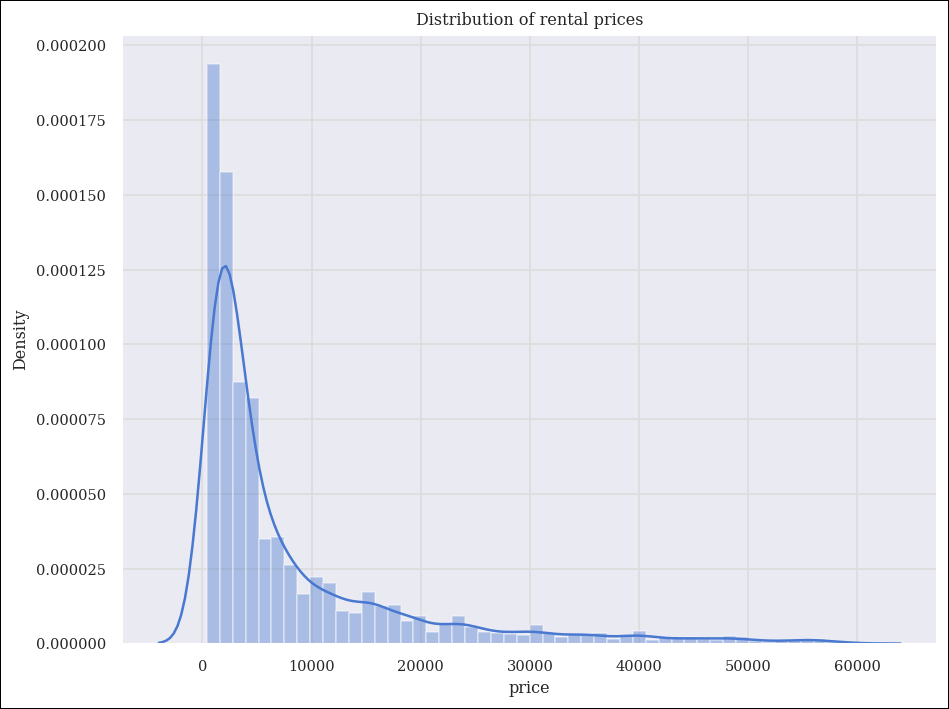

In [194]:
# plot price distribution of prices
plt.figure(num=1, figsize=(8,6), linewidth=1)
sns.distplot(df.price)

plt.title('Distribution of rental prices')
plt.tight_layout()
plt.savefig('price_distribution.png')
plt.show()

The distribution of prices is multimodal and right-tailed with most of the prices around the mean (GHS 7999).
The blue line above shows a probability "Density" function, which helps identify the regions in the regions the distribution where prices are more likely to occur.

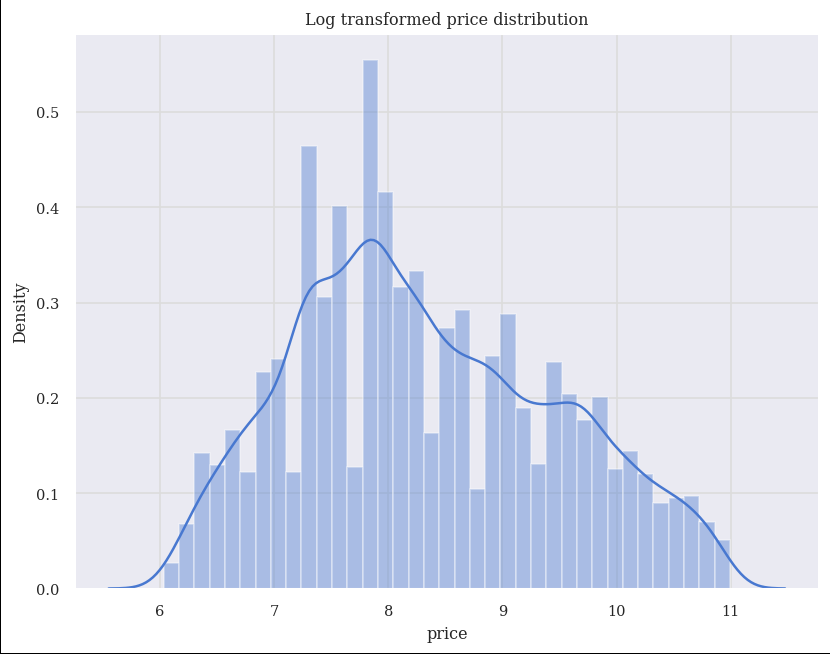

In [195]:
# plot log1p transformed price distribution of prices
plt.figure(num=1, figsize=(8,6), linewidth=1)
sns.distplot(np.log1p(df.price))

plt.title('Log transformed price distribution')
plt.show()

## Geolocation analysis

In this section, we aim to uncover some spatial distribution of listings and identify the neighbourhood that is mostly listed.

### Where are the houses listings located?

In [196]:
top_localities = df['locality'].value_counts().nlargest(20).index

df_top_localities = df[df['locality'].isin(top_localities)]['locality'].value_counts().to_frame().reset_index()
df_top_localities

,locality,count
0,East Legon,2565
1,Spintex,1800
2,Teshie,1334
3,Adenta,1253
4,Accra Metropolitan,1035
5,Ashaley Botwe,940
6,Kumasi Metropolitan,641
7,Adjiriganor,560
8,Oyarifa,540
9,Tema Metropolitan,473


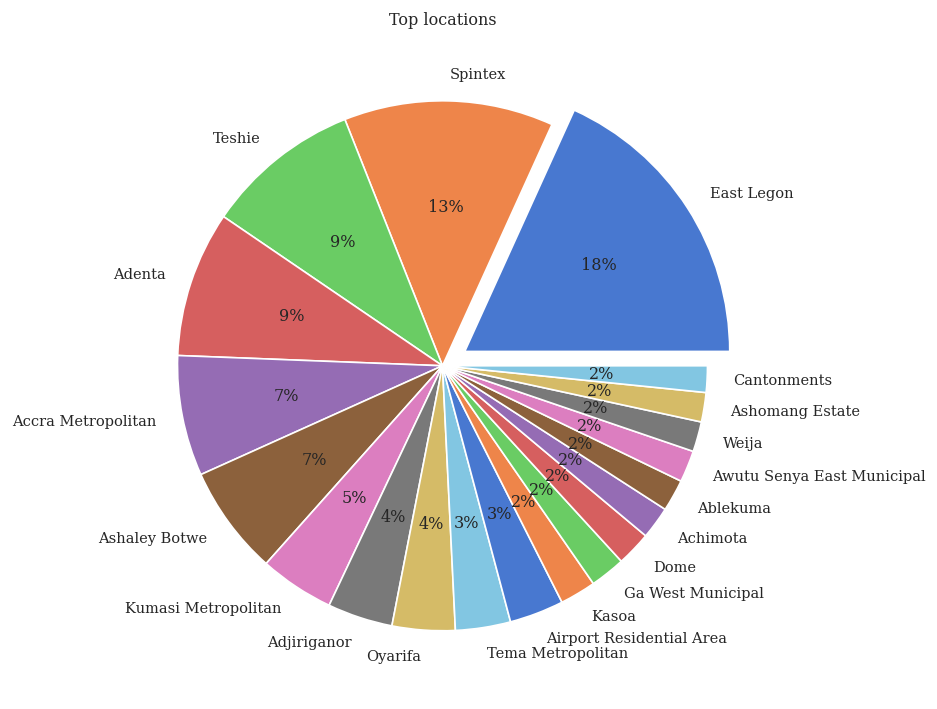

In [197]:
### Distribution of Listings in Locality
plt.figure(figsize=(12, 6))
explode = [0.1] + [0] * (df_top_localities.shape[0]-1)
# sns.countplot(x='locality', data=df[df['locality'].isin(top_10_localities)], order=top_10_localities)
plt.pie(df_top_localities['count'], labels=df_top_localities['locality'],
        explode=explode, autopct='%.0f%%')

# plt.xticks(rotation=45, ha='right')
plt.title('Top locations')
plt.tight_layout()
plt.savefig("top_locations.png")
plt.show()

In [198]:
ACCRA_CENTROID = [5.577412, -0.178909]

I'm using [Cantonments](https://maps.app.goo.gl/GaDRnhEagE2YmQr76) as the center for properties. For context banks use cantonments as center when evaluating houses. The expectation is that the further away from cantonments, the cheaper the property price.

In [199]:
# We'll use latitude and longitude values of each accommodation to calculate the distance to cantonments using
# the *Great-circle distance* algorithm implemented by `geopy.distance.great_circle` function.
from geopy.distance import great_circle

def distance_to_mid(lat, lon):
    """Function to calculate distance between 2 geographical coordinates"""
    return great_circle(ACCRA_CENTROID, (lat, lon)).km

In [200]:
df['distance_to_center'] = df.apply(lambda x: distance_to_mid(x.lat, x.lng), axis=1)

### Price differences by accommodation distance to Cantonments


<Figure size 1440x960 with 0 Axes>

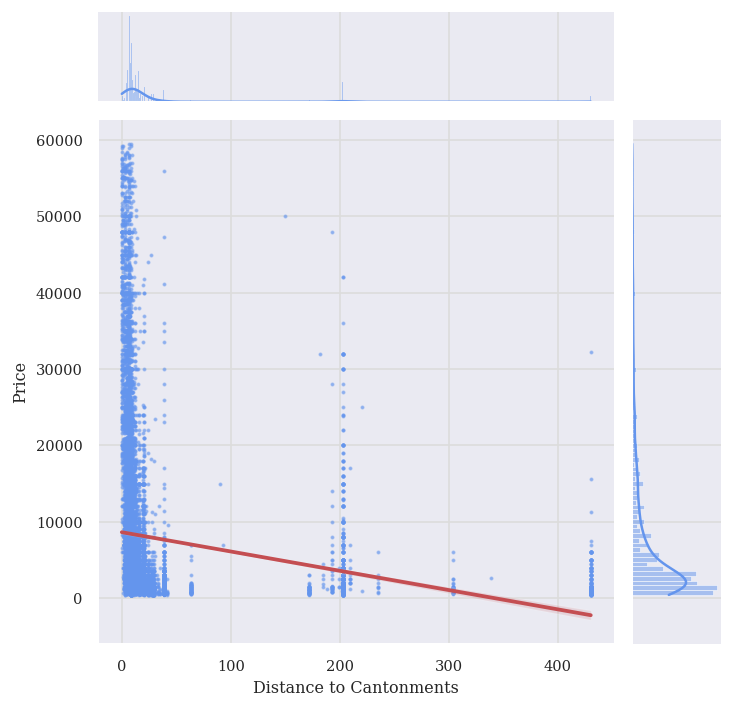

In [201]:
plt.figure(num=2, figsize=(12,8))
fig = sns.jointplot(
    x="distance_to_center", y="price", data=df, color='cornflowerblue',
    kind='reg', scatter_kws=dict(s=2, alpha=0.5), line_kws=dict(color='r')
)
plt.xlabel('Distance to Cantonments')
plt.ylabel('Price')
plt.show()

The regression plot above shows that highly-priced accommodation is located in the city centre. This distribution and density of prices were completely expected as central is an expensive place to live as well it's proximity to the business centre and areas of interest for tourist.

### Lets check how price varies within the top 10 neighbourhood

In [202]:
# Now let find out the price distribution of the top 10 locations
locality_table = []
n = 20

top_locality = df['locality'].value_counts().index[:n]
for b in top_locality:
    locality_table.append(df[df['locality'] == b]['price'].describe().T)

# print table
pd.DataFrame(locality_table, index=df['locality'].value_counts().index[:n]).sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
locality,,,,,,,,
Cantonments,227.0,36876.370044,12986.748345,6000.0,26900.0,39000.0,47950.00,59250.0
Airport Residential Area,466.0,21943.450644,15678.035904,800.0,8425.0,18436.5,33973.75,58200.0
East Legon,2565.0,14386.854191,12451.437038,500.0,5000.0,10000.0,19000.00,59524.0
Adjiriganor,560.0,12591.232143,10152.180211,700.0,5000.0,9788.0,16000.00,58000.0
Achimota,278.0,10989.118705,8398.239967,800.0,4000.0,10000.0,15000.00,42000.0
Accra Metropolitan,1035.0,9181.114010,9832.319106,500.0,2500.0,5000.0,12718.50,58500.0
Spintex,1800.0,6698.670000,7355.766703,450.0,2000.0,3800.0,8227.75,59267.0
Ashaley Botwe,940.0,5496.591489,5515.608951,500.0,2500.0,3500.0,6425.00,48000.0
Teshie,1334.0,5420.969265,8553.650642,420.0,1000.0,2000.0,5000.00,58300.0


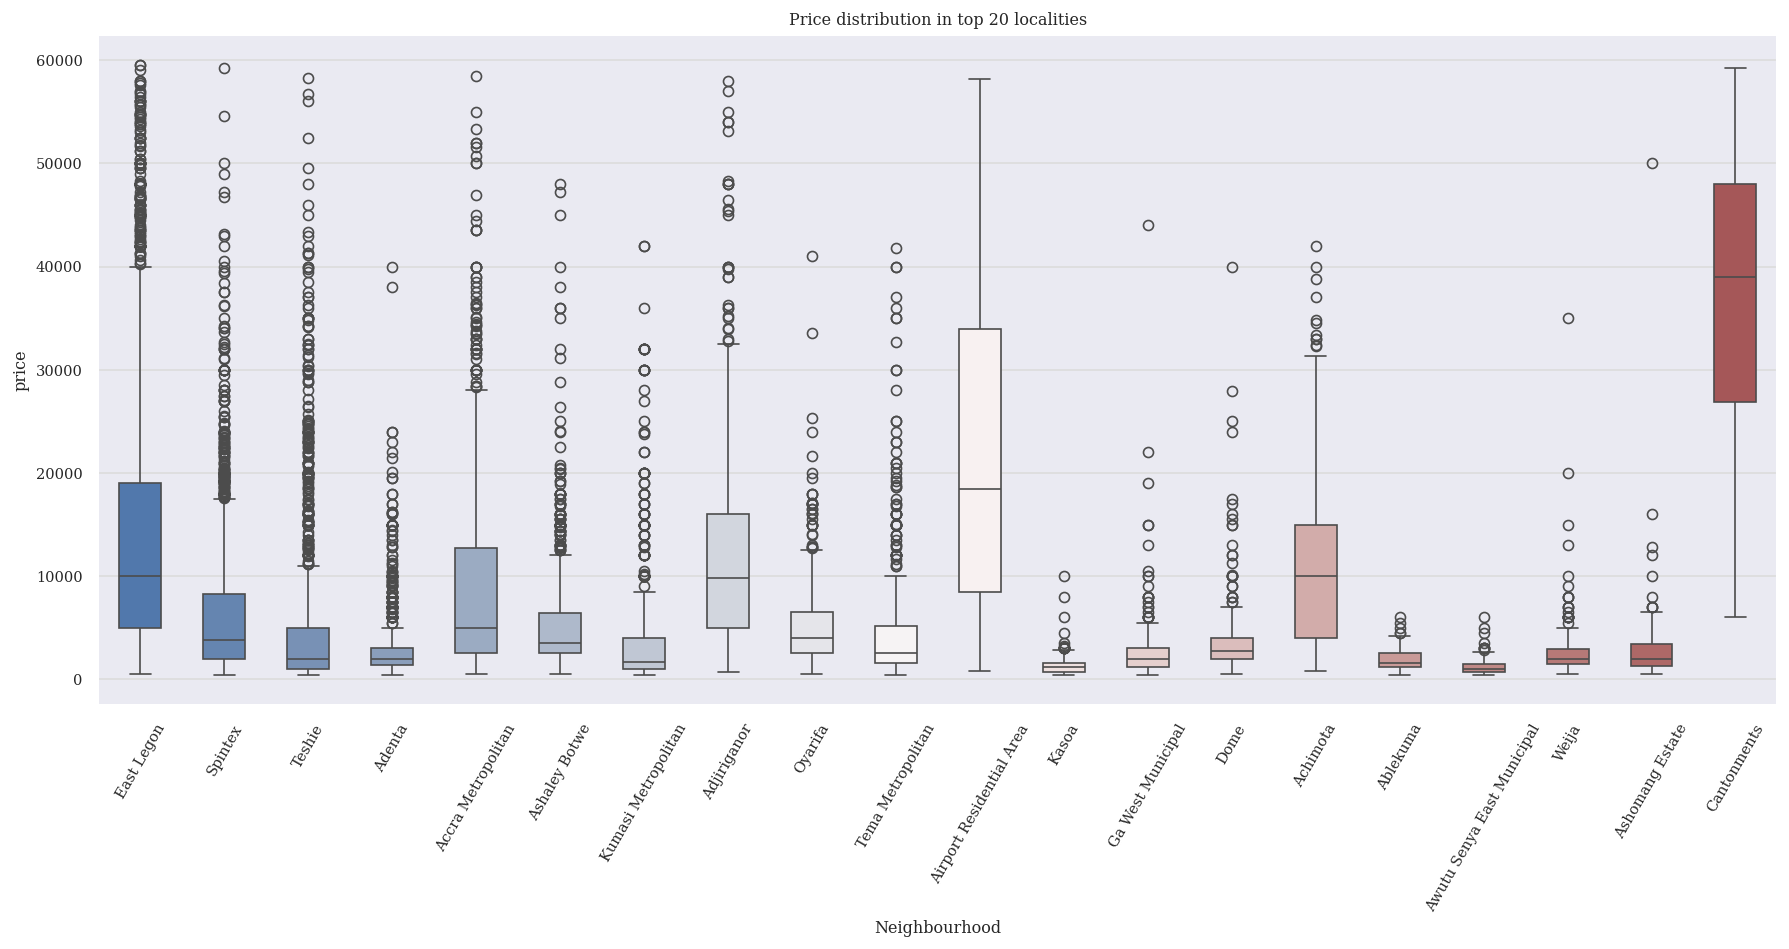

In [203]:
# Let's visualize the above table using violin plots
plt.figure(num=2, figsize=(15,8))
sns.boxplot(x='locality', y='price', data=df, order=top_locality, width=.5, palette="vlag", native_scale=True)
plt.title("Price distribution in top 20 localities")
plt.xlabel("Neighbourhood")
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig('top_locations_prices.png')
plt.show()

Great, with the above violin plot we can definitely observe a couple of things about the distribution of prices. First, we can state that East legon has the highest range of rent prices with an average of GHS 12,000, followed by Adjiriganor of average price GHS 10,000 per month.

Spintex, Ashaley Botwe, Oyarifa and Tema appear to have very similar distributions, Adenta and Kumasi looks to be the cheapest.

## House types

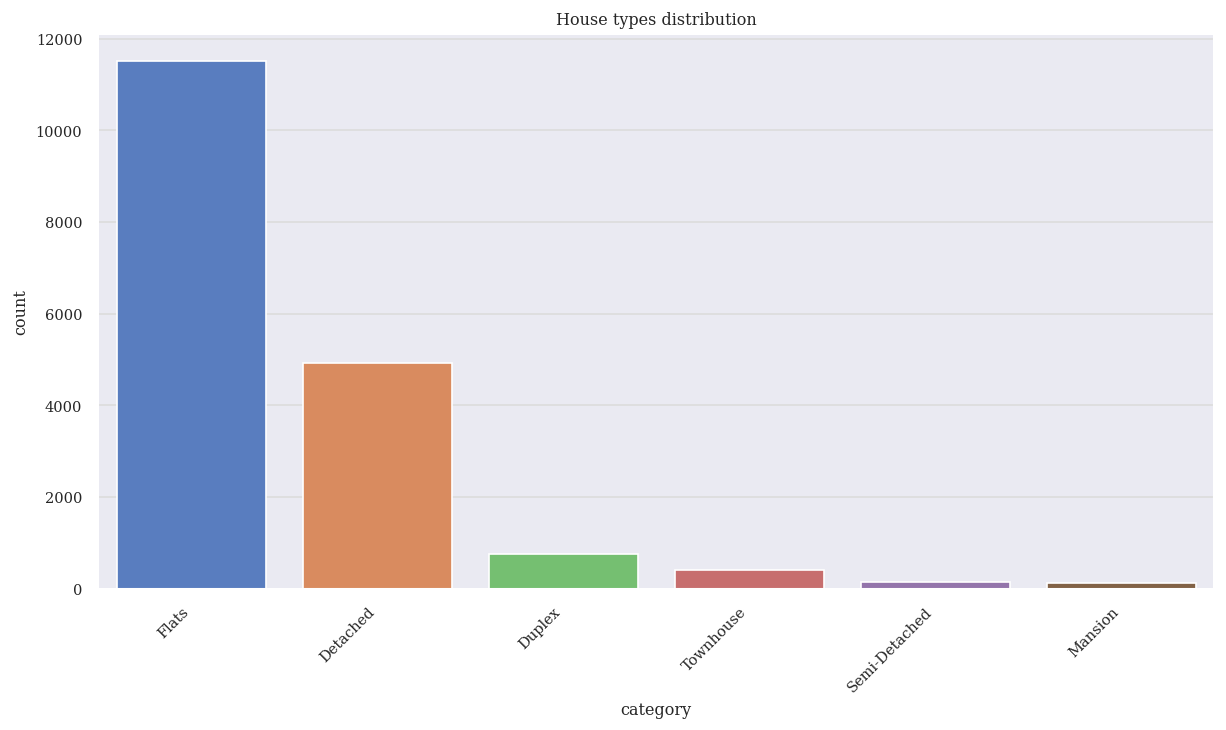

In [204]:
### Distribution of Listings by house types

plt.figure(figsize=(12, 6))

sns.countplot(x='category', data=df, order=df['category'].value_counts().index, palette="muted")
plt.xticks(rotation=45, ha='right')
plt.title('House types distribution')
plt.show()

## House Size Analysis

In [205]:
df['floor_area'].describe().T

,floor_area
count,17890.000000
mean,556.094913
std,1044.912578
min,10.000000
25%,100.000000
50%,145.000000
75%,600.000000
max,5000.000000


### Distribution of house sizes

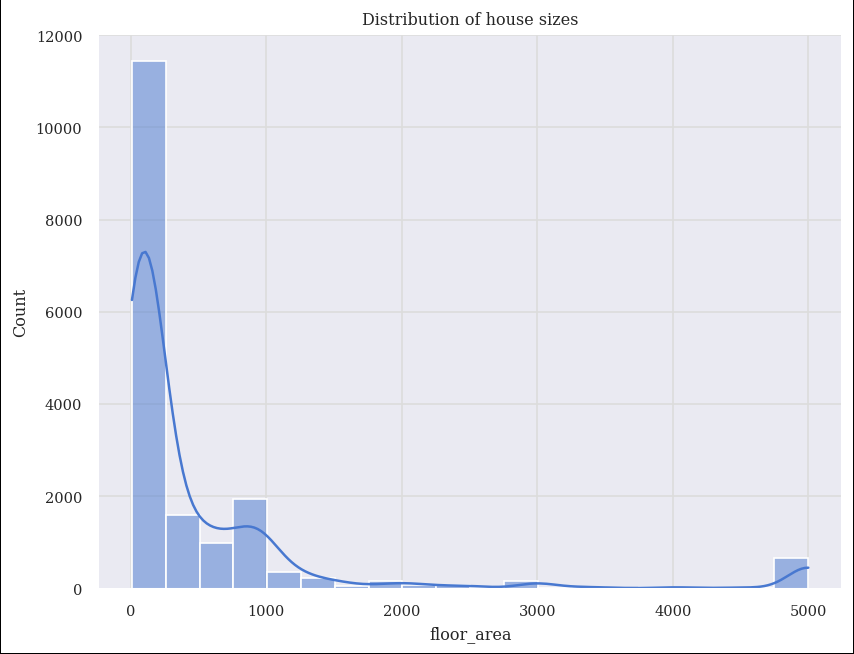

In [206]:
plt.figure(num=1, figsize=(8,6), linewidth=1)
sns.histplot(df['floor_area'], stat='count', kde=True, bins=20 )

plt.title('Distribution of house sizes')
plt.show()

### Rental prices vs size

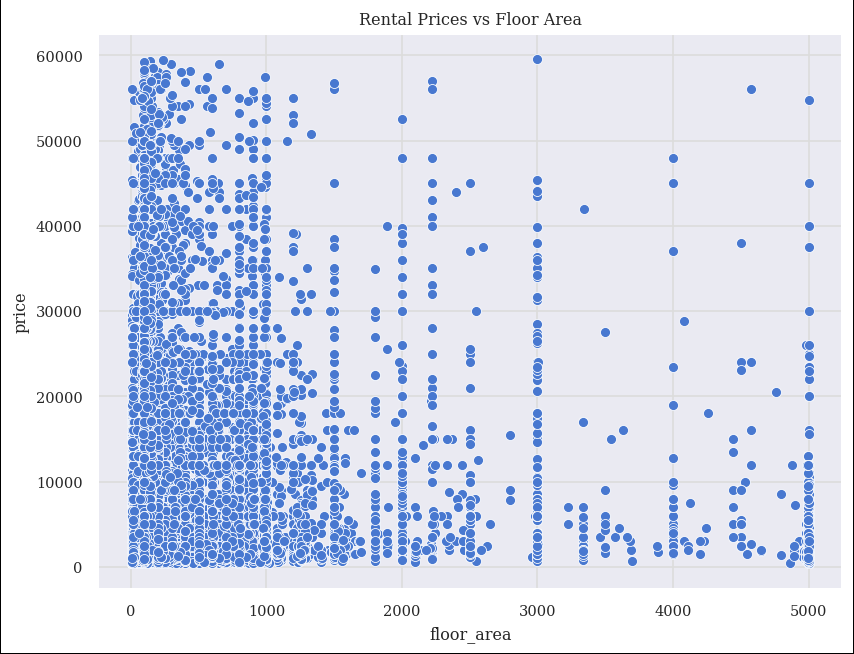

In [207]:
plt.figure(num=1, figsize=(8,6), linewidth=1)
sns.scatterplot(x='floor_area', y='price', data=df, )

plt.title('Rental Prices vs Floor Area')
plt.show()

### Price per square foot

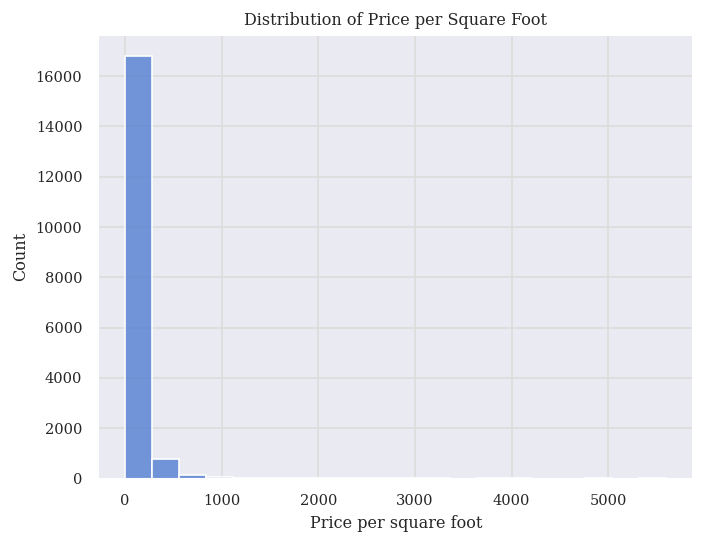

In [208]:
df['psf'] = df['price']/df['floor_area']

sns.histplot(df['psf'], stat='count', bins=20)
plt.title('Distribution of Price per Square Foot')
plt.ylabel('Count')
plt.xlabel('Price per square foot')
plt.show()

## House condition

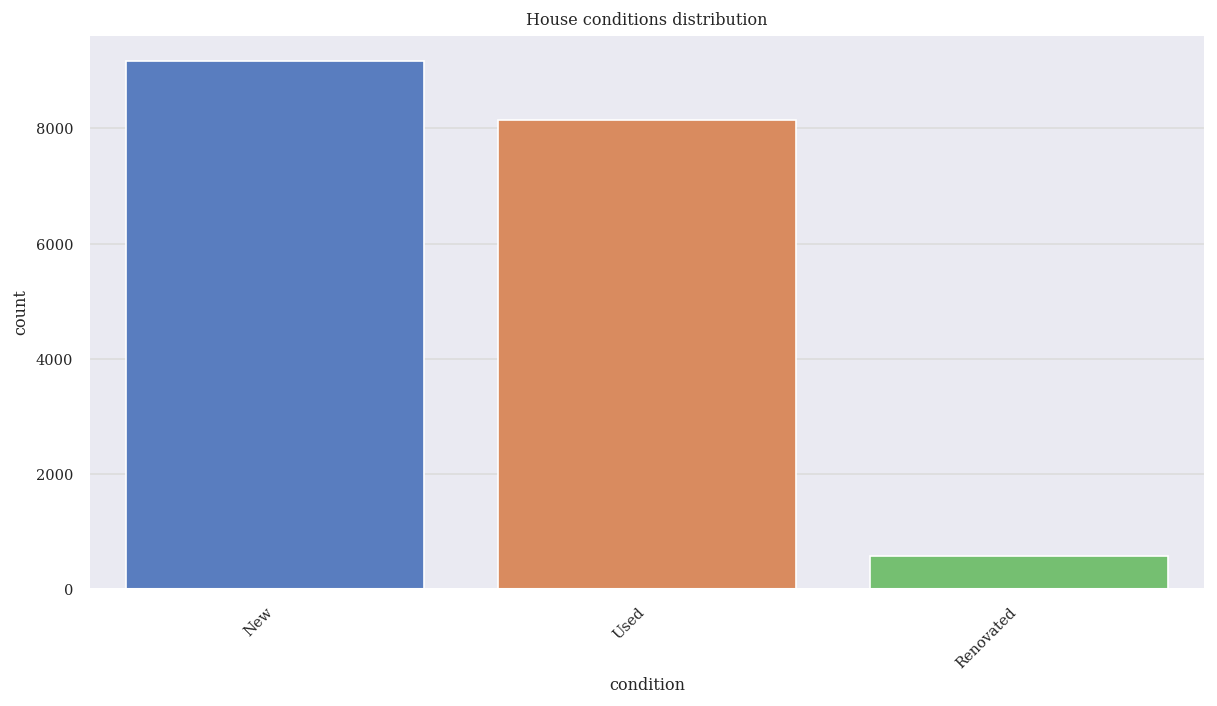

In [209]:
### Distribution of Listings by house types

plt.figure(figsize=(12, 6))

sns.countplot(x='condition', data=df, order=df['condition'].value_counts().index, palette="muted")
plt.xticks(rotation=45, ha='right')
plt.title('House conditions distribution')
plt.show()

## Furnished apartments


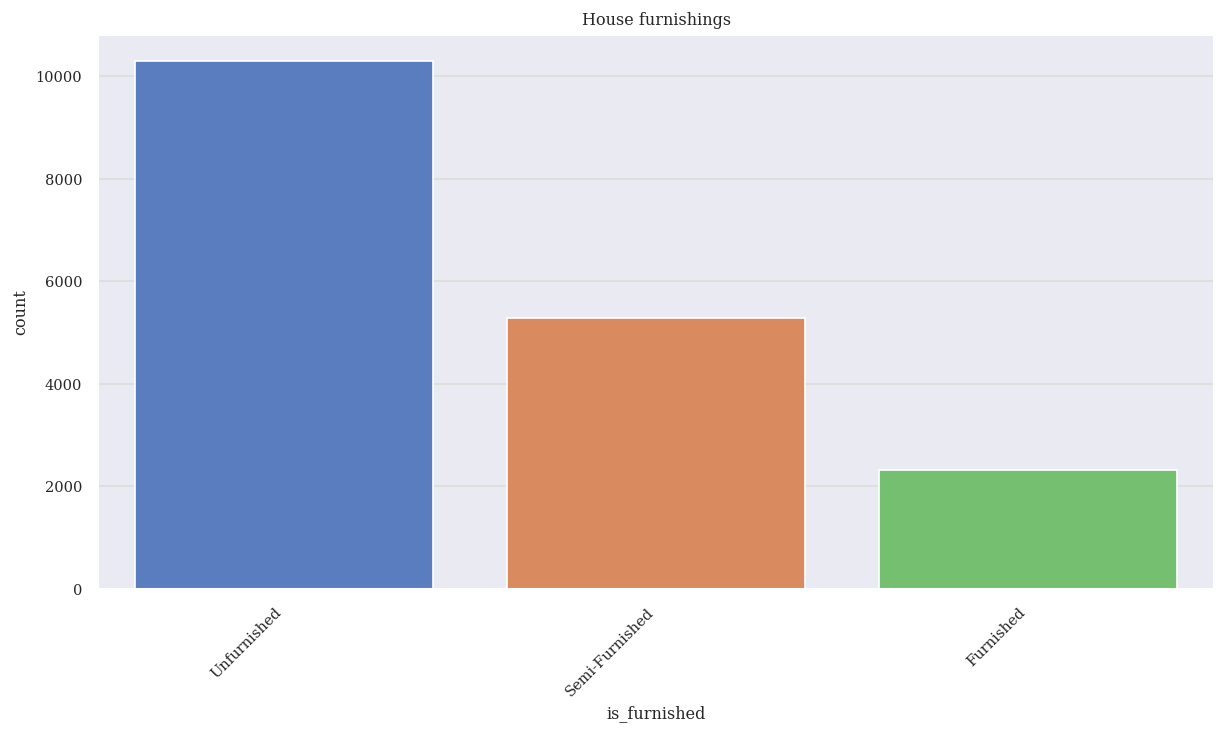

In [210]:
### Distribution of Listings by house types

plt.figure(figsize=(12, 6))

sns.countplot(x='is_furnished', data=df, order=df['is_furnished'].value_counts().index, palette="muted")
plt.xticks(rotation=45, ha='right')
plt.title('House furnishings')
plt.show()

## Amenities

In [211]:
# create a counter to count amentities in the dataset
results = Counter()
df.amenities.apply(lambda x: results.update(x.split(",")))
# create a new sub dataframe with 'amenity' and 'count'
amenity_df = pd.DataFrame(results.most_common(20), columns=['amenity', 'count'])
amenity_df.head(10)

,amenity,count
0,Tiled Floor,15820
1,Pre-Paid Meter,15521
2,Kitchen Cabinets,15420
3,24-hour Electricity,15255
4,Pop Ceiling,14212
5,Dining Area,11536
6,Balcony,11458
7,Kitchen Shelf,11190
8,Apartment,10499
9,Air Conditioning,9563


### Top amenities

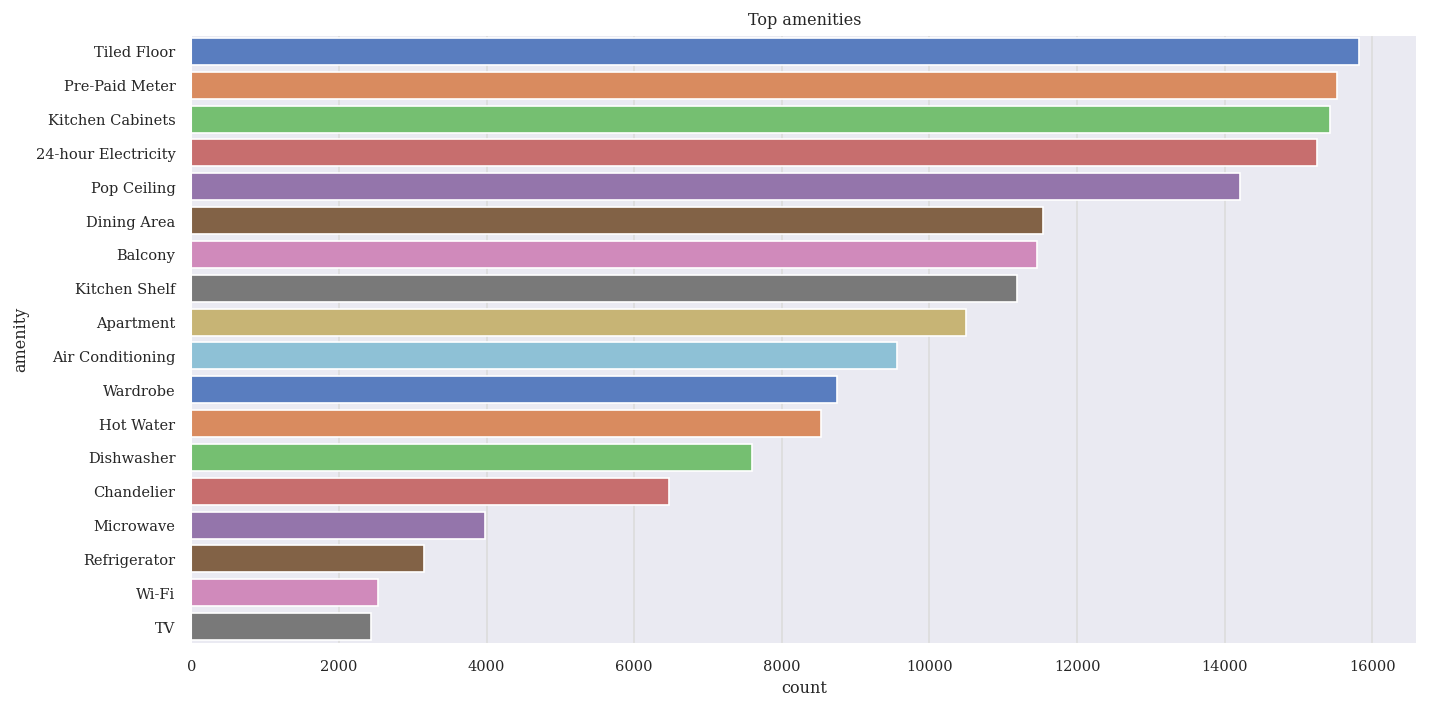

In [212]:
# plot top amentities
plt.figure(figsize=(12, 6))

sns.barplot(y='amenity', x='count', data=amenity_df, palette="muted")
plt.title("Top amenities")

# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_amenity.png')
plt.show()

### Number of amenities in each area

In [213]:
df['amenities_count'] = df['amenities'].apply(lambda x: len(x.split(',')))
# group by locations and then sum the amenities_count
g1 = df.groupby(['locality'])['amenities_count'].sum().reset_index().sort_values(by='amenities_count', ascending=False)

g1.head()

,locality,amenities_count
43,East Legon,29104
95,Spintex,19329
5,Accra Metropolitan,11273
104,Teshie,10801
9,Adenta,10709


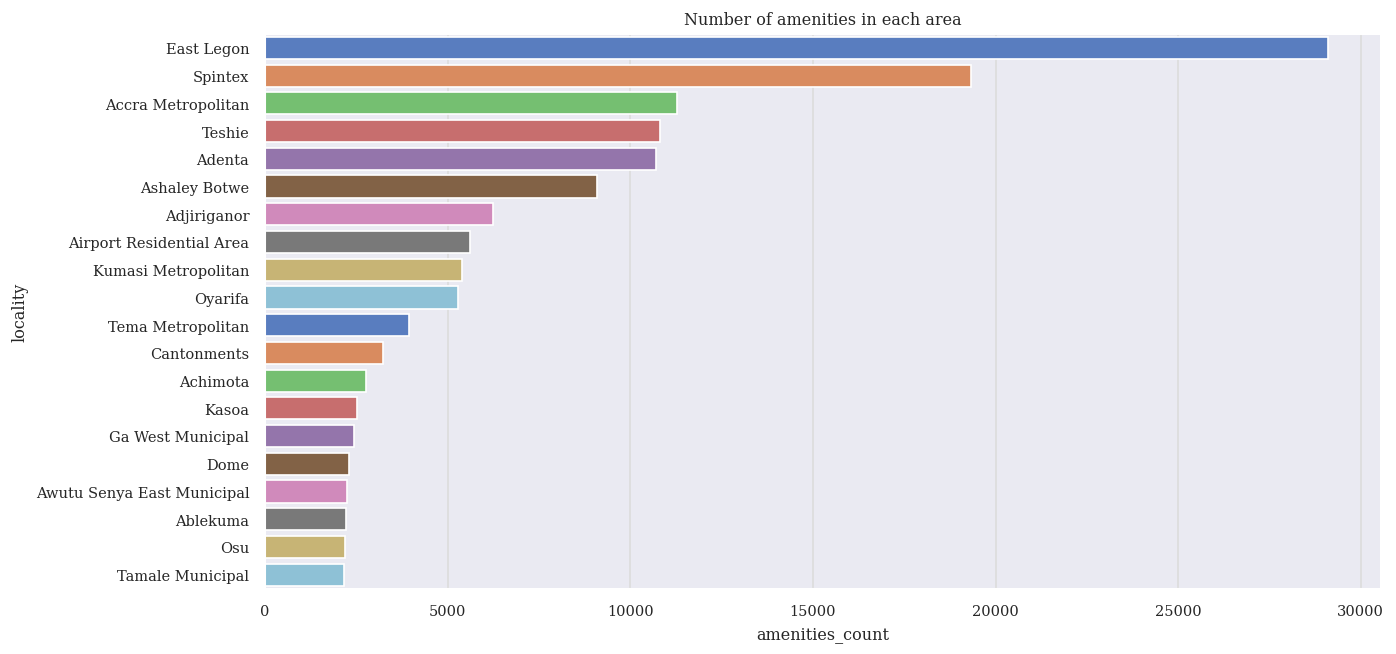

In [214]:
plt.figure(figsize=(12, 6))

sns.barplot(x='amenities_count', y='locality', data=g1, order=g1.locality.values[:20], palette="muted")
plt.title("Number of amenities in each area")
plt.show()

## Correlation

Here we visualize the correlation of each features with the listing prices

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url                 17890 non-null  object 
 1   listing_type        17890 non-null  object 
 2   name                17890 non-null  object 
 3   price               17890 non-null  int64  
 4   category            17890 non-null  object 
 5   bedrooms            17890 non-null  float64
 6   bathrooms           17890 non-null  float64
 7   floor_area          17890 non-null  float64
 8   location            17890 non-null  object 
 9   condition           17890 non-null  object 
 10  amenities           17890 non-null  object 
 11  region              17890 non-null  object 
 12  locality            17890 non-null  object 
 13  parking_space       17890 non-null  bool   
 14  is_furnished        17890 non-null  object 
 15  lat                 17890 non-null  float64
 16  lng 

In [216]:
# Correlation Matrix Heatmap
numeric_features = [
    'bathrooms', 'bedrooms', 'floor_area',
    'amenities_count', 'lat', 'lng', 'price'
]
# standardize numerical attribute using zscore
corr_df = df[numeric_features]
scaled_values = StandardScaler().fit_transform(corr_df)
corr_df.loc[:,numeric_features] = scaled_values

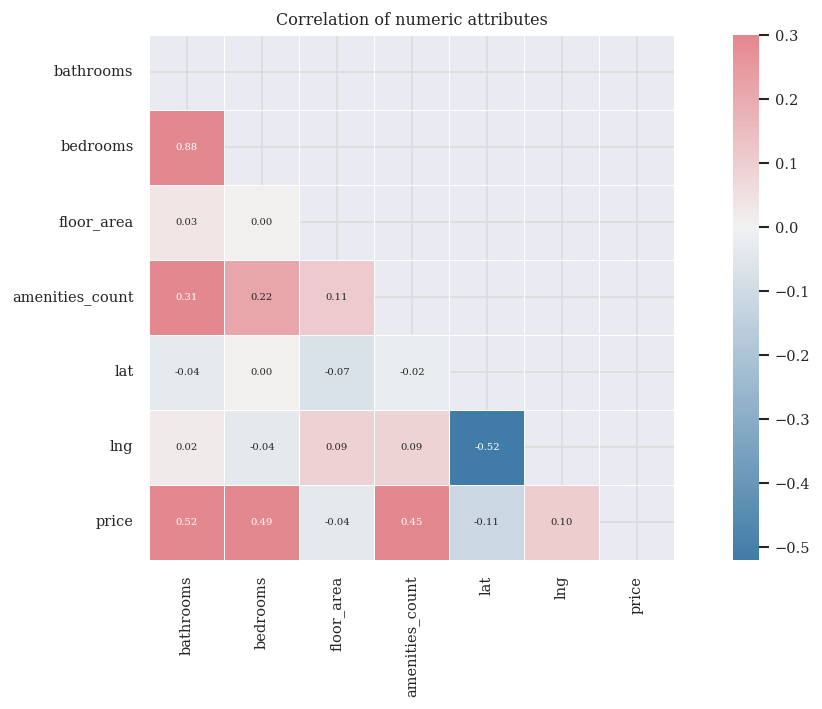

In [217]:
fig, ax = plt.subplots(figsize=(10, 6))
# first normalize values and calculate correlation using pearson correlation.
corr = corr_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, fmt='.2f', annot=True,
            annot_kws={"size": 6}, ax=ax,
           )
plt.title("Correlation of numeric attributes")
plt.tight_layout()
plt.savefig('correlation.png')
plt.show()

The gradients in the heatmap above vary based on the strength of the correlation, and can effortlessly spot potential attributes having strong correlations amongst themselves. For price, we can see number of bathrooms have a weak correlation of 0.52